In [1]:
import os
print(os.getcwd())

/work/LAS/jernigan-lab/sarwar/protein_class2


In [2]:
!python --version

Python 3.10.16


In [3]:
#!pip install torch

In [4]:
import torch

# Check if GPU is available
gpu_available = torch.cuda.is_available()
print(f"Is GPU available? {gpu_available}")

# If GPU is available, print additional details
if gpu_available:
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")

Is GPU available? True
Number of GPUs: 1
Current GPU: Tesla V100-PCIE-16GB


In [5]:
# Check GPU for LSTM and BERT models to run
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


In [6]:
#!pip install pandas
#!pip install matplotlib
#!pip install evaluate
#!pip install transformers
#!pip install seaborn
#!pip install scikit-learn
#!pip install tensorboard
#!pip install transformers[torch] # it will install accelerate

In [7]:
import os
import pandas as pd
from collections import Counter
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import evaluate
from torch.utils.tensorboard import SummaryWriter

/work/LAS/jernigan-lab/sarwar/.conda/envs/plmclass2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

path = '/work/LAS/jernigan-lab/sarwar/protein_class'

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(path, partition)):
    with open(os.path.join(path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [9]:
# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

# reading all data_partitions
df_train = read_data('random_split/train')
df_val = read_data('random_split/dev')
df_test = read_data('random_split/test')


df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,DUF4476,D2VQ42_NAEGR/277-371,PF14771.6,QVSPMAGSDLIRVISLF.GFESDKVKAVQQL....KKTNNIATMDC...,QVSPMAGSDLIRVISLFGFESDKVKAVQQLKKTNNIATMDCSTACS...
1,FtsA,A5VJ35_LACRD/207-368,PF14450.6,VVIDLGGGQTTTSIIHDHQ....LKY...............TYVD....,VVIDLGGGQTTTSIIHDHQLKYTYVDPEGGKYITKDISTVMNTSLK...
2,Ribosomal_L36,RL36_CHLT3/1-38,PF00444.18,MKVSSSVGKRC....ESCKI.............I.....RRK.......,MKVSSSVGKRCESCKIIRRKGKIYVICKKNPNHKQRQG
3,7TM_GPCR_Srt,O16478_CAEEL/5-313,PF10321.9,MSLYYVFTHSFSL.PPEYDCP.....EN.VNVS.ATTRPFLGAYFL...,MSLYYVFTHSFSLPPEYDCPENVNVSATTRPFLGAYFLLTGIVLEI...
4,RnaseA,ANG2_BOVIN/3-115,PF00074.20,DAYRGFLRKHYDPSPTGHDD...RYCNTMMERRNM..TR....P.....,DAYRGFLRKHYDPSPTGHDDRYCNTMMERRNMTRPCKDTNTFIHGN...


In [10]:
def select_family_subset(df_train, df_val, df_test, selected_families):
    """
    Selects and returns a subset of the dataset containing only the specified families.
    """
    # Filter datasets to include only the selected families
    df_train_subset = df_train[df_train['family_id'].isin(selected_families)]
    df_val_subset = df_val[df_val['family_id'].isin(selected_families)]
    df_test_subset = df_test[df_test['family_id'].isin(selected_families)]

    return df_train_subset, df_val_subset, df_test_subset

# List of selected 10 families
#selected_families = ['LRR_1', 'Acetyltransf_7', 'His_kinase', 'Bac_transf',
  #  'Lum_binding', 'DNA_binding_1', 'Chromate_transp',
   # 'Lipase_GDSL_2', 'DnaJ_CXXCXGXG', 'SRP54_N']

## top 20 families, selected.

selected_families = ['Methyltransf_25', 'LRR_1', 'Acetyltransf_7', 'His_kinase', 'Bac_transf', 'Lum_binding', 
       'DNA_binding_1', 'Chromate_transp', 'Lipase_GDSL_2', 'DnaJ_CXXCXGXG', 'SRP54_N', 
       'OTCace_N', 'WD40', 'PEP-utilizers', 'Glycos_trans_3N', 'THF_DHG_CYH', 'Prenyltransf', 
       'HTH_1', 'Maf', 'DHH']

# Select the subset of data for further analysis
df_train_subset, df_val_subset, df_test_subset = select_family_subset(df_train, df_val, df_test, selected_families)

# Now df_train_subset, df_val_subset, and df_test_subset can be used for further analysis


/scratch/sarwar/2105315/ipykernel_618472/2514404301.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
/scratch/sarwar/2105315/ipykernel_618472/2514404301.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
/scratch/sarwar/2105315/ipykernel_618472/2514404301.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='family_id', order=df['family_i

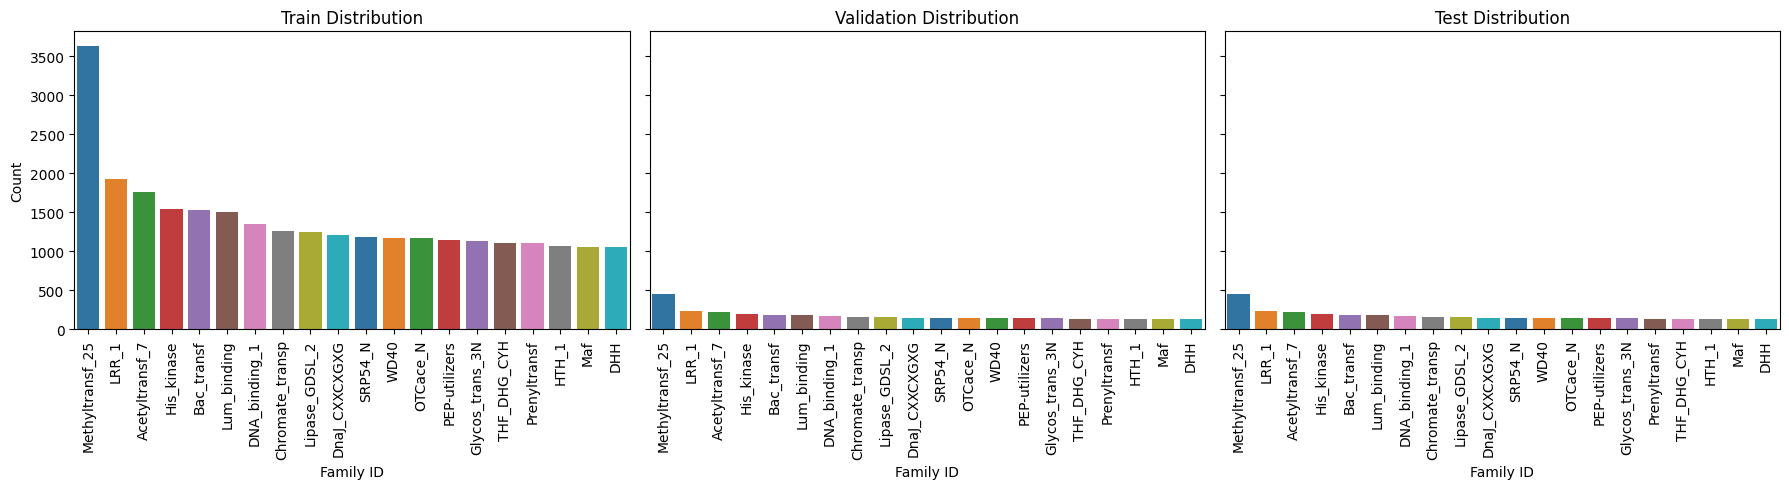

In [11]:
def plot_family_counts(df_train_subset, df_val_subset, df_test_subset):
    """Plots the distribution of family counts for train, val, and test datasets."""
    # Define the datasets and titles
    datasets = [df_train_subset, df_val_subset, df_test_subset]
    titles = ['Train', 'Validation', 'Test']

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for ax, df, title in zip(axes, datasets, titles):
        # Create a count plot for each dataset
        sns.countplot(data=df, x='family_id', order=df['family_id'].value_counts().index, ax=ax, palette='tab10')
        ax.set_title(f'{title} Distribution')
        ax.set_xlabel('Family ID')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better visibility

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot the family counts for the training, validation, and test datasets
plot_family_counts(df_train_subset, df_val_subset, df_test_subset)

In [12]:
 class SeqDataset(torch.utils.data.Dataset):
  '''This class is used to create a dataset for the model'''
  def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

  def __getitem__(self, idx):
      item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
      item['labels'] = torch.tensor(self.labels[idx])
      return item

  def __len__(self):
      return len(self.labels)

In [13]:
# use subset of dataset
dataset_train = df_train_subset
dataset_dev = df_val_subset
dataset_test = df_test_subset

# ================================================ use all dataset
#dataset_train = df_train
#dataset_dev = df_val
#dataset_test = df_test

class_count_dic = dataset_train['family_id'].value_counts().to_dict() # class count dictionary contains the class name and the number of samples in the class

classes = list(class_count_dic.keys()) # select all classes ============================================

In [14]:
class_count_dic

{'Methyltransf_25': 3637,
 'LRR_1': 1927,
 'Acetyltransf_7': 1761,
 'His_kinase': 1537,
 'Bac_transf': 1528,
 'Lum_binding': 1504,
 'DNA_binding_1': 1345,
 'Chromate_transp': 1265,
 'Lipase_GDSL_2': 1252,
 'DnaJ_CXXCXGXG': 1210,
 'SRP54_N': 1185,
 'WD40': 1173,
 'OTCace_N': 1171,
 'PEP-utilizers': 1147,
 'Glycos_trans_3N': 1138,
 'THF_DHG_CYH': 1113,
 'Prenyltransf': 1104,
 'HTH_1': 1064,
 'Maf': 1061,
 'DHH': 1057}

In [15]:
# here we retrieve the different datasets based on the selected classes
dataset_train_small= dataset_train
dataset_dev_small= dataset_dev
dataset_test_small= dataset_test

In [16]:
# here we calculate the length of the sequences in the train set
sequence_len_df = dataset_train_small['sequence'].apply(len)
max_len = int(np.median(np.quantile(sequence_len_df, 0.99))) # we set max_len to be the percentile 99th so we don't have to zero-pad all sequences to be length of a sequence that the longest

In [17]:
max_len

238

In [18]:
# label encoding for converting classes to integers
le = LabelEncoder()
y_train_int = le.fit_transform(dataset_train_small['family_id'])
y_dev_int = le.transform(dataset_dev_small['family_id'])
y_test_int = le.transform(dataset_test_small['family_id'])
# ====================================================================== --------------- # max_len ==============
#tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D", do_lower_case=False, model_max_length = max_len) 

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D", do_lower_case=False, model_max_length= max_len)

train_encodings = tokenizer(dataset_train_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")

dev_encodings = tokenizer(dataset_dev_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")
test_encodings = tokenizer(dataset_test_small['sequence'].to_list(), truncation=True, padding=True, return_tensors="pt")

train_dataset = SeqDataset(train_encodings, y_train_int)
dev_dataset = SeqDataset(dev_encodings, y_dev_int)
test_dataset = SeqDataset(test_encodings, y_test_int)

In [19]:
import os

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /work/LAS/jernigan-lab/sarwar/protein_class2


In [20]:
# remove previous log, if any
#!rm -rf ./results_35M_20c/training_logs
#!rm -rf ./results_35M_20c/training_results

In [21]:
# Create directories if not already present
output_dir = './results_35M_20c/training_results'
logging_dir = './results_35M_20c/training_logs'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import EarlyStoppingCallback, TrainerCallback

#model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels= len(classes))

model = AutoModelForSequenceClassification.from_pretrained("facebook/esm2_t12_35M_UR50D", num_labels= len(classes))

model.to(device)  # Move model to GPU or CPU depending on the availability

eps = 30
bs = 16
steps = len(train_dataset) // bs

metric = evaluate.load('accuracy')

def compute_acc(eval_pred):
    '''This function is used to compute the accuracy of the model'''
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,            # Output directory for checkpoints
    num_train_epochs=eps,             # Number of training epochs
    per_device_train_batch_size=bs,   # Batch size for training
    per_device_eval_batch_size=bs,    # Batch size for evaluation
    warmup_steps=500,                 # Warmup steps for learning rate scheduler
    weight_decay=0.01,                # Weight decay
    logging_dir=logging_dir,          # Directory for logs
    logging_steps=steps,              # Steps interval for logging
    logging_strategy="steps",         # Log at regular intervals
    load_best_model_at_end=True,      # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Save the best model -- accuracy
    evaluation_strategy='epoch',      # Evaluate at the end of every epoch
    save_strategy='epoch',            # Save checkpoints at the end of every epoch
    learning_rate=4e-3               # learning rate
)

# Early stoping
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop training if no improvement after 2 evaluations
    early_stopping_threshold=0.001  # Minimum improvement required to consider it as better
)

trainer = Trainer(
    model=model,                                        # the instantiated Transformers model to be trained
    args=training_args,                                 # training arguments, defined above
    train_dataset=train_dataset,                        # training dataset
    eval_dataset=dev_dataset,                           # evaluation dataset
    compute_metrics = compute_acc,
    tokenizer=tokenizer,
    #callbacks=[early_stopping]  # Adding EarlyStoppingCallback
    )

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/work/LAS/jernigan-lab/sarwar/.conda/envs/plmclass2/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/scratch/sarwar/2105315/ipykernel_618472/2497089141.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
#!pip install wandb -qU
import wandb

In [24]:
# ... login 

wandb.login(key="xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

# Before trainer.train()
wandb.init(project="HPC_project", name="35M_c20_hpc") # Initialize wandb with your project name

# train function starts the training
print("Starting training...")
trainer.train()
print("Training completed.")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sarwarisu24 (sarwarisu24-iowa-state-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/sarwar/.netrc


Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy
1,0.772200,0.918189,0.728852
2,1.547700,1.446033,0.489034
3,1.268600,1.203933,0.612931
4,0.945000,0.897598,0.698377
5,1.032600,1.330612,0.514099
6,0.947700,0.899771,0.678724
7,0.894700,0.849796,0.685844
8,0.828900,0.729051,0.754201
9,0.828600,0.582035,0.806893
10,0.795300,0.701787,0.749359


/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/scr

Training completed.


In [25]:
# ... (after training) ...
print("Finishing wandb...")
#wandb.finish() # Close the wandb run
print("wandb finished.")

Finishing wandb...
wandb finished.


In [34]:
df = pd.DataFrame(trainer.state.log_history)
# Extract metrics
training_loss = df['loss'].dropna().tolist()
validation_loss = df['eval_loss'].dropna().tolist()
validation_accuracy = df['eval_accuracy'].dropna().tolist()

# Extract epochs (from even-numbered rows only)
epochs = df.loc[(df.index + 1) % 2 == 0, 'epoch'].dropna().unique().astype(int)

# Ensure data alignment for plotting
aligned_training_loss = training_loss[:len(epochs)]
aligned_validation_loss = validation_loss[:len(epochs)]
aligned_validation_accuracy = validation_accuracy[:len(epochs)]

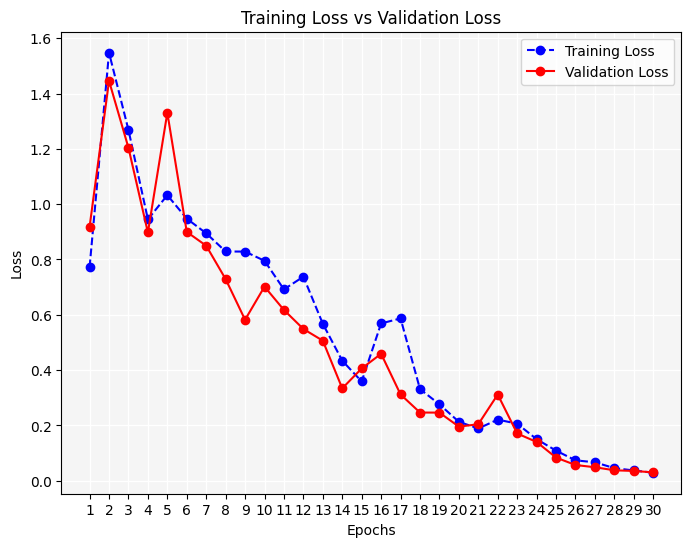

In [35]:
# Plotting
plt.figure(figsize=(8, 6))

# Plot data
plt.plot(epochs, aligned_training_loss, label="Training Loss", color="blue", marker='o', linestyle='--')
plt.plot(epochs, aligned_validation_loss, label="Validation Loss", color="red", marker='o', linestyle='-')

# Customize plot
plt.title("Training Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

# Add white vertical and horizontal lines
plt.grid(color='white', linestyle='-', linewidth=1)

# Set the grid's background
plt.gca().set_facecolor('whitesmoke')  # Optional for a light gray background

plt.show()

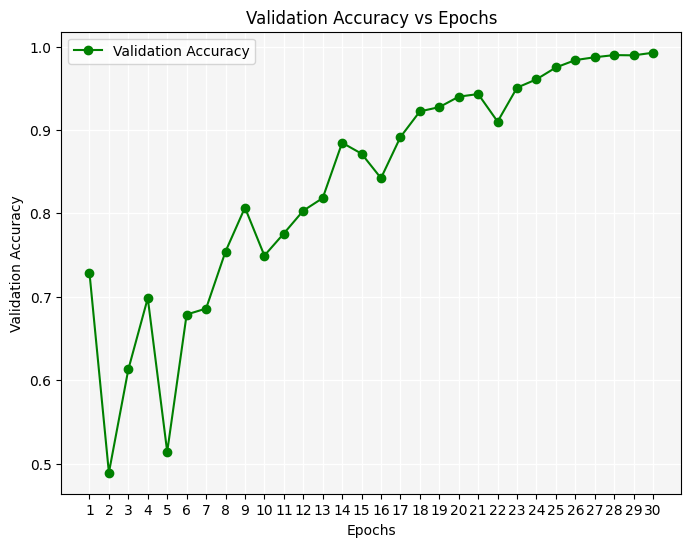

In [36]:
# Replace zeros with a small positive value
#validation_accuracy = [max(acc, 1e-6) for acc in aligned_validation_accuracy]

# Plotting
plt.figure(figsize=(8, 6))

# Plot data
plt.plot(epochs, aligned_validation_accuracy, label="Validation Accuracy", color="green", marker='o', linestyle='-')

# Customize plot
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.xticks(epochs)
plt.legend()

# Use logarithmic scale for y-axis
#plt.yscale('log')

# Add white vertical and horizontal lines
plt.grid(color='white', linestyle='-', linewidth=1)

# Set the grid's background
plt.gca().set_facecolor('whitesmoke')  # Optional for a light gray background

plt.show()


In [30]:
# evaluate function evaluates the model on the input dataset
#wandb.login(key="15c5a4c7787aee681bea83a5b9f995855e551b84")

# Before trainer.train()
#wandb.init(project="HPC_project", name="35M_10_test") # Initialize wandb with your project name

trainer.evaluate(test_dataset)

# ... (after testing) ...
print("Finishing wandb...")
#wandb.finish() # Close the wandb run
print("wandb finished.")

/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Finishing wandb...
wandb finished.


/scratch/sarwar/2105315/ipykernel_618472/1956749121.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


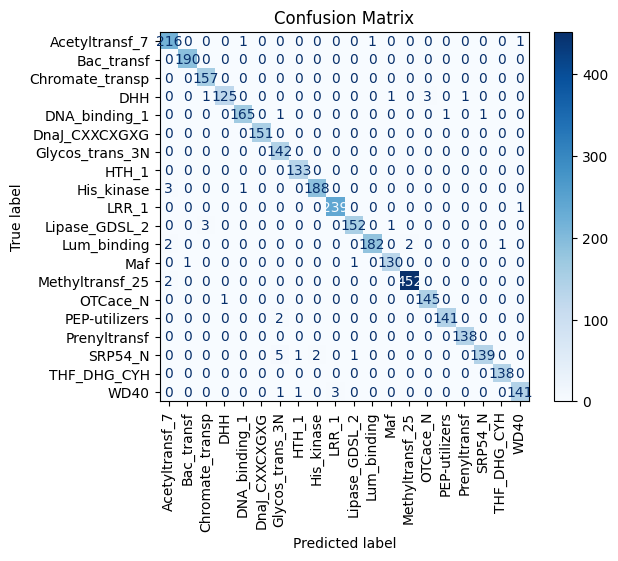

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test dataset
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()


In [32]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)


                 precision    recall  f1-score   support

 Acetyltransf_7       0.97      0.99      0.98       219
     Bac_transf       0.99      1.00      1.00       190
Chromate_transp       0.98      1.00      0.99       157
            DHH       0.99      0.95      0.97       131
  DNA_binding_1       0.99      0.98      0.99       168
  DnaJ_CXXCXGXG       1.00      1.00      1.00       151
Glycos_trans_3N       0.94      1.00      0.97       142
          HTH_1       0.99      1.00      0.99       133
     His_kinase       0.99      0.98      0.98       192
          LRR_1       0.99      1.00      0.99       240
  Lipase_GDSL_2       0.99      0.97      0.98       156
    Lum_binding       0.99      0.97      0.98       187
            Maf       0.98      0.98      0.98       132
Methyltransf_25       1.00      1.00      1.00       454
       OTCace_N       0.98      0.99      0.99       146
  PEP-utilizers       0.99      0.99      0.99       143
   Prenyltransf       0.99    

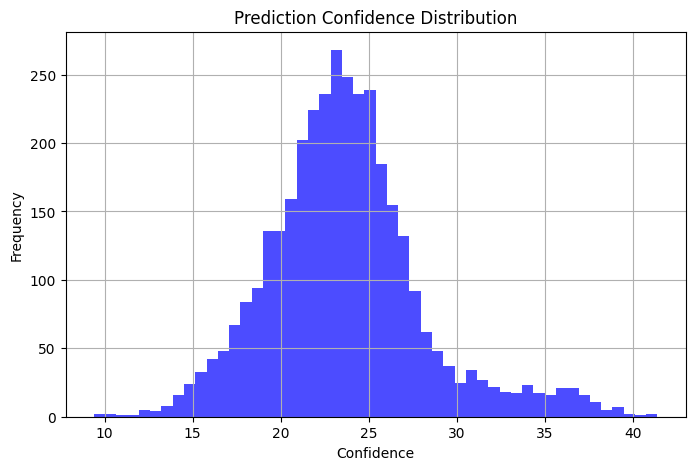

In [33]:
probs = np.max(predictions.predictions, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(probs, bins=50, alpha=0.7, color='blue')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Prediction Confidence Distribution")
plt.grid(True)
plt.show()